## 1- EDA (Exploratory Data Anlysis) ##

Realizaremos un análisis sobre las variables que utilizará el modelo y prepararemos los datos para su uso.

Importamos las librerias necesarias.

In [1037]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Leemos el dataset previamente generado para su análisis.

In [1038]:
data = pd.read_csv('Dataset/clean_data.csv')

Listaremos los campos y obtendremos información de los mismos para evaluar cuáles serán utilizados.

In [1039]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45452 entries, 0 to 45451
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  4497 non-null   object 
 1   budget                 45452 non-null  float64
 2   genres                 43067 non-null  object 
 3   id                     45452 non-null  int64  
 4   original_language      45441 non-null  object 
 5   overview               44511 non-null  object 
 6   popularity             45452 non-null  float64
 7   production_companies   33634 non-null  object 
 8   production_countries   39232 non-null  object 
 9   release_date           45452 non-null  object 
 10  revenue                45452 non-null  float64
 11  runtime                45206 non-null  float64
 12  spoken_languages       41554 non-null  object 
 13  status                 45372 non-null  object 
 14  tagline                20425 non-null  object 
 15  ti

Obtendremos la cantidad de valores faltantes en cada uno de los campos.

In [1040]:
data.isna().sum().sort_values(ascending=False)

belongs_to_collection    40955
tagline                  25027
production_companies     11818
production_countries      6220
spoken_languages          3898
genres                    2385
cast                      2355
overview                   941
crew                       836
runtime                    246
status                      80
original_language           11
release_date                 0
revenue                      0
budget                       0
popularity                   0
title                        0
vote_average                 0
vote_count                   0
return                       0
release_year                 0
id                           0
dtype: int64

Eliminaremos aquellas columnas que tengan más de la mitad de datos faltantes.

In [1041]:
data.drop(columns=['belongs_to_collection', 'tagline'], inplace=True)

Verificaremos la existencia de registros duplicados y los eliminaremos.

In [1042]:
data.drop_duplicates(inplace=True)

Tomaremos solo las películas que han salido y eliminaremos el campo _`status`_ que ahora no posee utilidad.

In [1043]:
data = data.loc[(data["status"]=="Released")]
data.drop(columns=['status'], inplace=True)

Usaremos variables principalmente cuantitativas o coheficientes para el modelado, por lo tanto, no tomaremos variables relacionadas al lenguaje o cadenas de texto como _`spoken_languages`_, _`original_languages`_, etc.

In [1044]:
data.drop(columns=['spoken_languages', 'original_language', 'overview'], inplace=True)

No podemos afirmar necesariamente que la fecha de lanzamiento o duración de la película sea un factor suficientemente relevante para el modelo.

In [1045]:
data.drop(columns=['release_year', 'release_date', 'runtime'], inplace=True)

Aunque los campos _`budget`_, _`revenue`_ y _`return`_ son coheficientes que podrían ser útiles para la descripción de las películas en el modelo, poseen muchos valores inconclusos de transformaciones previas por lo que serán eliminados.

In [1046]:
print('Valores nulos en el campo budget: ' + str( len(data[data['budget'] == 0])) )
print('Valores nulos en el campo revenue: ' + str( len(data[data['revenue'] == 0])) )
print('Valores nulos en el campo return: ' + str( len(data[data['return'] == 0])) )


Valores nulos en el campo budget: 36061
Valores nulos en el campo revenue: 37529
Valores nulos en el campo return: 39544


In [1047]:
data.drop(columns=['budget','revenue', 'return'], inplace= True)

No consideramos relevantes los campos _`production_companies`_, _`production_countries`_, _`crew`_ y _`cast`_ para el análisis y aunque pudieramos hacer coheficientes de correlación como sucederá con la columna de _`genres`_ o dumies, nos separaría demasiados los grupos del modelo haciendoló menos eficiente.

In [1048]:
data.drop(columns=['production_companies', 'production_countries', 'crew', 'cast'], inplace= True)

Por último, eliminaremos el campo _`vote_count`_ al no poder afirmar su influencia en _`voto_average`_  y la columna _`id`_ al identificar las películas por el campo _`title`_. Reordenaremos los campos restantes por comodidad.
  

In [1049]:
data.drop(columns=['vote_count', 'id'], inplace= True)

Reindexaremos para encontrar los registros más facilmente y no perder trazabilidad de los mismo. También, realizaremos una copia para traer el título de la película luego de usar el modelo.

In [1050]:
data = data.reset_index(drop=True)
copia = data.copy()

La data ha quedado de este modo luego de las transformaciones:

In [1051]:
data.head(3)

,genres,popularity,title,vote_average
0,"Animation, Comedy, Family",21.946943,Toy story,7.7
1,"Adventure, Fantasy, Family",17.015539,Jumanji,6.9
2,"Romance, Comedy",11.712900,Grumpier old men,6.5


Exportaremos la data que utilizará el modelo.

In [1052]:
data.to_csv('Dataset/model_data.csv', index=False)

## 2- Modelo de Machine Learning ##

Mostraremos la realización del modelo que será implementado en la recomendación de películas, explicando su funcionamiento y uso.

Crearemos un coheficiente que mida la relación en base a la cantidad de géneros que comparte la película seleccionada con las demás, armando grupos en base a la similitud de géneros de las películas. 

  Para esto, haremos que cada uno de los géneros previamente formateados vuelvan a ser una lista, en la que cada género representará un elemento de la misma.

In [1053]:
data['genres'] = data['genres'].apply(lambda x: str(x).split(', '))

Utilizaremos un ejemplo de película al azar

In [1054]:
pelicula = data['title'].sample(1).values[0]


Localizaremos el indice del registro que representa a esa película

In [1055]:
indice = data[data['title'] == pelicula].index[0]

Asignaremos a nuestra variable la lista de géneros que tiene la película seleccionada

In [1056]:
generos = data['genres'][indice]

In [1057]:
data.loc[indice]

genres          [Drama, Romance]
popularity              1.033814
title           The hidden blade
vote_average                 7.6
Name: 10908, dtype: object

Obtendremos un coheficiente que representará la similitud entre los géneros de las película en el Dataset y la seleccionada por el usuario.
  
  Los coheficientes serán calculados revisando registro a registro, la cantidad de géneros que comparten o tienen en común una película 'x' con la actual.
  
  Así tendremos un valor capaz de medir el parecido entre los géneros de ambas.

In [1058]:
coef = []

for h in data['genres']:
    num = 0
    for m in generos:
                
        if(m in h): num += 1
    coef.append(num)
    


Los posibles coheficientes de una película respecto a la actual podrán ser estos:

In [1059]:
set(coef)

{0, 1, 2}

Crearemos el campo _`coef`_ para guardar los valores obtenidos y nos desharemos de la columna  _`genres`_.

In [1060]:
data['coef'] = coef
data = data[['coef','popularity','vote_average']]

Asignaremos a nuestra variable **'X'** los valores del dataframe.

In [1061]:
X = data.values
X

array([[0.0000000e+00, 2.1946943e+01, 7.7000000e+00],
       [0.0000000e+00, 1.7015539e+01, 6.9000000e+00],
       [1.0000000e+00, 1.1712900e+01, 6.5000000e+00],
       ...,
       [1.0000000e+00, 9.0300700e-01, 3.8000000e+00],
       [0.0000000e+00, 3.5030000e-03, 0.0000000e+00],
       [0.0000000e+00, 1.6301500e-01, 0.0000000e+00]])

Definiremos nuestro punto de _`reference_point`_ dado por la película acutal para trazar vectores y obtener en _`nearby_points`_ aquellos puntos que se encuentren dentro del radio seleccionado.

  En caso de que quisieramos asegurar tener al menos un número n de recomendaciones podríamos subir el radio, ya que de no encontrar al menos n puntos el modelo devolvera una cantidad menor. Esto no generará un costo computacional mucho más alto debido que se descartarán luego todos menos los n más cercanos.

In [1062]:

reference_point = X[:,0][indice], X[:,1][indice], X[:,2][indice]

# Calcular la distancia euclidiana entre los puntos y el punto de referencia
distances = np.linalg.norm(X - reference_point, axis=1)

# Definir un radio de cercanía para los puntos
radius =  1.5

# Filtrar los puntos cercanos al punto de referencia
nearby_points = X[distances < radius]


Definiremos en la variable _`amount`_ la cantidad de recomendaciones que queremos obtener. Iteraremos obteniendo las distancias absolutas a nuestro punto de referencia.

In [1063]:
amount = 5

ind_min = []

# Guardaremos además de la distancia un indice para identificar el punto

for z,  i in enumerate(nearby_points):
    
# Utilizaremos la distancia euclidiana para definir la distancia entre 2 puntos, lo que será dado por la suma de lo que se 
# debe recorrer (diferencia) en cada dimensión o plano entre un punto cualquiera y nuestro punto de referencia.


    ind_min.append([sum(abs(reference_point - i)), z]) 
    
# Ordenaremos la lista para obtener luego las n distancias más cercanas, al tener su índice podemos saber de que puntos 
# se trata. Nos salteamos la distancia 0 ya que es el punto actual dado por la distancia 0.0 (ubicado en el mismo lugar).

ind_min.sort()
ind_min = [i[1] for i in ind_min][1:(amount + 1)]



Guardaremos los puntos que luego serán buscados en todos los valores de X.

In [1064]:
points = nearby_points[ind_min]
points

array([[2.      , 1.123477, 7.6     ],
       [2.      , 1.125284, 7.6     ],
       [2.      , 1.036233, 7.7     ],
       [2.      , 1.141182, 7.6     ],
       [2.      , 1.016039, 7.5     ]])

Buscaremos los índices donde las coordenadas coinciden en X para obtener el índice del registro real de nuestro Dataframe.

In [1065]:
coordenadas = points[:, 1:]
indices_coincidentes = np.where(np.isin(X[:, 1:], coordenadas).all(axis=1))[0]

print("Índices coincidentes:", indices_coincidentes)

Índices coincidentes: [13755 16383 34061 34624 37141]


Obtendremos los datos de las películas que se recomendaron a modo de ejemplo.

In [1066]:
for i in indices_coincidentes:
    print(copia.loc[i])

genres          Drama, Romance
popularity            1.016039
title                 La ronde
vote_average               7.5
Name: 13755, dtype: object
genres           Drama, Romance, War
popularity                  1.125284
title           Le silence de la mer
vote_average                     7.6
Name: 16383, dtype: object
genres          Fantasy, Animation, Drama, Science Fiction, Ro...
popularity                                               1.141182
title                                      Princes and princesses
vote_average                                                  7.6
Name: 34061, dtype: object
genres          Romance, Drama
popularity            1.123477
title           A summer story
vote_average               7.6
Name: 34624, dtype: object
genres                    Drama, Romance
popularity                      1.036233
title           Vinnaithaandi varuvaayaa
vote_average                         7.7
Name: 37141, dtype: object


Ahora gráficaremos el modelo para entender qué es lo que está haciendo de manera viusal.
Aquí, nuestro punto de referencia estará dado por una cruz color negro y nuestras recomendaciones serán los puntos rojos de su alrededor.

In [1067]:
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_scatter(x1, x2, y, ax=None, fig = None):
    if (fig is None) and (ax is None):
        fig = plt.figure(figsize = (12,10))
        ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, x2, y, alpha = 0.02)
    ax.scatter(X[:,0][indice], X[:,1][indice], X[:,2][indice], c='black', s=2000, marker = '+')
    for i in points:
        ax.scatter(i[0], i[1], i[2], c='red', s=50)
    

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')

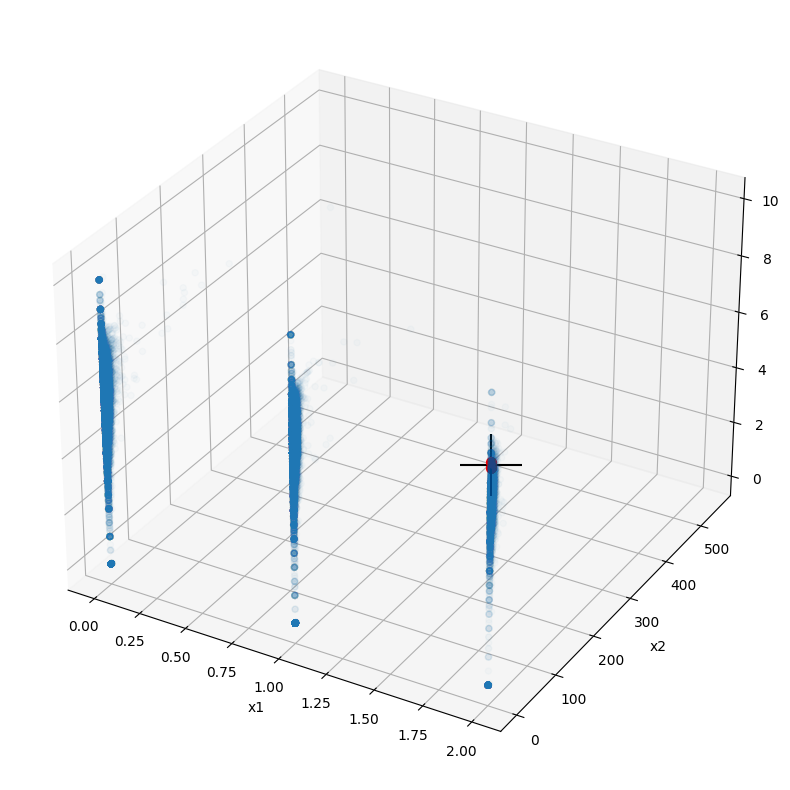

In [1068]:
plot_3d_scatter(X[:,0], X[:,1], X[:,2], ax=None, fig = None)

Podemos ver que el modelo está dando puntos similares al nuestro o en otras palabras películas parecidas.

    Este modelo puede ser utilizado en muchos ámbitos y con la cantidad de coheficientes o features que se necesite, ya que al buscar las distancias vectoriales entre puntos, ya sea para reconocer el comportamiento de un grupo dado por el radio, identificar registros atípicos o evaluar comportamientos similares para una recomendación o búsqueda puede trazarse en n dimensiones sin problemas.
    También se puede quitar o dar más importancia a algún coheficiente ponderando los valores, las posibilidades son bastantes espero les guste :)